# Data loading with ExternalSource operator
In this notebook, we will see how to use the `ExternalSource` operator, which allows us to use an external data source as input to the Pipeline.

This notebook derived from: https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/general/data_loading/external_input.html

In [1]:
%matplotlib inline
import collections
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from nvidia.dali.pipeline import Pipeline
from nvidia.dali import ops, types

batch_size = 16

## Defining the data source
We use an infinite iterator as a data source, on the sample dogs & cats images.

In [2]:
class ExternalInputIterator:
    def __init__(self, batch_size):
        self.images_dir = 'data/images/'
        self.batch_size = batch_size
        with open(self.images_dir + 'file_list.txt') as file:
            self.files = [line.rstrip() for line in file if line]
        shuffle(self.files)
    
    def __iter__(self):
        """ (this is not typical __iter__ ?) """
        self.i = 0
        self.n = len(self.files)
        return self
    
    def __next__(self):
        batch  = []
        labels = []
        for _ in range(self.batch_size):
            jpg_fname, label = self.files[self.i].split(' ')
            file = open(self.images_dir + jpg_fname, 'rb')
            batch.append(np.frombuffer(file.read(), dtype=np.uint8))
            labels.append(np.array([label], dtype=np.uint8))
            self.i = (self.i + 1) % self.n
        return batch, labels

# Defining the pipeline
The next step is to define the Pipeline.

The `ExternalSource` op accepts an iterable or a callable. If the source provides multiple outputs (eg images and labels), that number must also be specified as `num_outputs` argument.

Internally, the pipeline will call `source` (if callable) or run `next(source)`(if iterable) whenever more data is needed to keep the pipeline running.

In [3]:
ext_input_iter = ExternalInputIterator(batch_size)

In [4]:
class ExternalSourcePipeline(Pipeline):
    def __init__(self, batch_size, ext_inp_iter, 
                 num_threads, device_id):
        super().__init__(batch_size, num_threads, device_id, seed=12)
        self.source  = ops.ExternalSource(source=ext_inp_iter, num_outputs=2)
        self.decode  = ops.ImageDecoder(device='mixed', output_type=types.RGB)
        self.enhance = ops.BrightnessContrast(device='gpu', contrast=2)
        
    def define_graph(self):
        jpgs, labels = self.source()
        images = self.decode(jpgs)
        output = self.enhance(images)
        return output, labels

# Using the Pipeline

In [5]:
ext_pipe = ExternalSourcePipeline
pipe = ext_pipe(batch_size, ext_input_iter, num_threads=2, device_id=0)
pipe.build()
pipe_out = pipe.run()

Notice that labels are still on CPU and no `as_cpu()` call is needed to show them.

In [6]:
batch_cpu  = pipe_out[0].as_cpu()
labels_cpu = pipe_out[1]  # already on cpu!

In [7]:
print(type(batch_cpu))
dir(batch_cpu)

<class 'nvidia.dali.backend_impl.TensorListCPU'>


['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'as_array',
 'as_reshaped_tensor',
 'as_tensor',
 'at',
 'copy_to_external',
 'data_ptr',
 'is_dense_tensor',
 'layout']

(427, 640, 3)
[0]


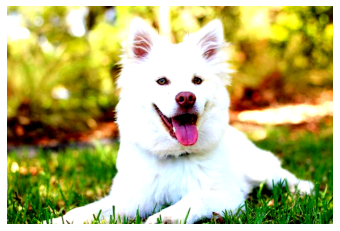

In [8]:
img = batch_cpu.at(2)
print(img.shape)
print(labels_cpu.at(2))
plt.axis('off')
plt.imshow(img)

### Lingering questions....
- Why do we need `ExternalSource` at all here?
  - we already have `ops.FileReader` and `ops.ImageDecoder`, so what is the purpose of having `ExternalSource`?